# Predicting drug response from multi-omic measurements

In this notebook, I will apply a variational autoencoder (VAE) inspired model to take as input proteomics, transcriptomics, and methylation data to predict drug response across 175 lung cancer cell lines.

## Biological question and rationale for modeling

Modern genomics approaches allow us to get detailed insight into several cellular phenotypes such as chromatin accessibility, transcript levels, protein abundance, among others. How these phenotypes map to 1) drug response or 2) gene essentiality are very relevant from a therapeutic / drug development standpoint. For instance, if we had a model trained on vast omics datasets, we could answer questions like:

- can we identify promising drug candidates for cell lines with omics data but limited drug response measurements?
- alteratively, can we identify conditionally essential genes as preliminary targets for therapeutic development?

In this modeling problem, I will focus on predicting drug response from three measurement types: transcriptomics, proteomics, and methylation.

## Modeling framework

I will apply a VAE framework (with an encoder and decoder), typically used to reconstruct inputs and learn embeddings, to instead predict drug response. The intuition behind this is that model training maps input omics datasets to drug response through a latent space representation. I decided to use a VAE instead of a transformer because:
- the probabilistic representation of inputs in VAEs can help prevent overfitting through latent space regularization
- VAEs are much faster to train than transformer based models
- there's only 175 cancer cell models, and a large transformer model could overfit to the limited data

## Imports

In [1]:
import os
from typing import List, Optional
from tqdm import tqdm

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_squared_error

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset

## Lung cancer datasets

In [4]:
lung_datasets = {}
for file in os.listdir(f"Dataset/Lung"):
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(f"Dataset/Lung", file), index_col=0)
        dict_key = file.replace("_imputed", "").replace("_latest", "").replace(".csv", "").split("_")[-1]
        lung_datasets[dict_key] = df

In [5]:
list(lung_datasets.keys())

['crisprcas9',
 'metabolomics',
 'transcriptomics',
 'fusions',
 'copynumber',
 'proteomics',
 'drugresponse',
 'methylation']

**Modify the assay types if you'd like to build other predictive models**

Fusions are not represented in a wide-form dataset, so the code here cannot handle it correctly.

In [6]:
training_assays = ["transcriptomics", "proteomics", "methylation"]
target_assay = "drugresponse"

In [7]:
lung_training_data = pd.concat(
    [lung_datasets[key] for key in training_assays if key != "fusions"], axis=1
)
lung_target_data = lung_datasets[target_assay]

## VAE predictive model

Classes for constructing the VAE based prediction model in PyTorch

In [8]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim: int, 
                 hidden_layer_sizes: List[int], 
                 nonlinear_activation: nn.Module, 
                 latent_dim: int):
        """
        multilayer perceptron encoder class
        
        Arguments:
        - input_dim (int): number of features in the training data
        - hidden_layer_sizes (List[int]): list of # nodes in hidden layers
        - nonlinear_activation (nn.Module): activation function
        - latent_dim (int): number of latent space dimensions
        
        """
        super().__init__()
        self.input_dim = input_dim
        self.hidden_layer_sizes = hidden_layer_sizes
        self.nonlinear_activation = nonlinear_activation
        self.latent_dim = latent_dim
        
        # defining the encoder layers
        self.hidden_layers = nn.ModuleList([])
        for idx in range(len(hidden_layer_sizes)):
            if idx == 0:
                self.hidden_layers.append(nn.Linear(input_dim, self.hidden_layer_sizes[idx]))
            else:
                self.hidden_layers.append(nn.Linear(self.hidden_layer_sizes[idx-1], 
                                                    self.hidden_layer_sizes[idx]))
        
        # output layers with mu and logvar
        self.mu_layer = nn.Linear(self.hidden_layer_sizes[-1], latent_dim)
        self.logvar_layer = nn.Linear(self.hidden_layer_sizes[-1], latent_dim)
        
    def forward(self, x):
        """
        Arguments: 
        - x (tensor): input tensor for each cancer cell line
        
        Returns:
        - mu and logvar for the latent space for each cancer cell line
        """
        for layer in self.hidden_layers:
            x = self.nonlinear_activation(layer(x))
        mu = self.mu_layer(x)
        logvar = self.logvar_layer(x)

        return mu, logvar

In [9]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim: int, 
                 hidden_layer_sizes: List[int], 
                 nonlinear_activation: nn.Module, 
                 latent_dim: int):
        """
        multilayer perceptron decoder class
        
        Arguments:
        - output_dim (int): number of features to predict
        - hidden_layer_sizes (List[int]): list of # nodes in hidden layers
        - nonlinear_activation (nn.Module): activation function
        - latent_dim (int): number of latent space dimensions
        """
        super().__init__()
        self.latent_dim = latent_dim
        self.hidden_layer_sizes = hidden_layer_sizes
        self.output_dim = output_dim
        self.nonlinear_activation = nonlinear_activation
        
        # defining the encoder layers
        self.hidden_layers = nn.ModuleList([])
        for idx in range(len(hidden_layer_sizes)):
            if idx == 0:
                self.hidden_layers.append(nn.Linear(latent_dim, self.hidden_layer_sizes[idx]))
            else:
                self.hidden_layers.append(nn.Linear(self.hidden_layer_sizes[idx-1], 
                                                    self.hidden_layer_sizes[idx]))
        
        # prediction layer
        self.predict_layer = nn.Linear(self.hidden_layer_sizes[-1], output_dim)
        
    def forward(self, x):
        """
        Arguments: 
        - x (tensor): sample from latent space
        
        Returns:
        - prediction (tensor): tensor for model prediction for each feature
        """
        for layer in self.hidden_layers:
            x = self.nonlinear_activation(layer(x))
        prediction = self.predict_layer(x)

        return prediction

In [10]:
class VAE(nn.Module):
    def __init__(self, 
                 input_dim: int, 
                 output_dim: int, 
                 nonlinearity: "str"="relu", 
                 latent_dim: int=64,
                 hidden_layer_sizes: Optional[List[int]] = None,):
        """
        VAE based predictive model class. Instead of reconstructing the input, the decoder predicts
        the output variable. In this framework, the latent space is a lower-dimensional mapping from the 
        input to the output variables.
        
        Arguments:
        - input_dim (int): number of dimensions in input data
        - output_dim (int): number of features to predict
        - nonlinearity (str): type of nonlinearity to apply between hidden layers, relu by default
        - latent_dim (int): dimensionality of the latent space representation
        - hidden_layer_sizes (List[int]): defines number of hidden layers and nodes in each layer, defaults
            to [256, 128]
        """
        super().__init__()
        
        # default parameter for hidden layer sizes
        if hidden_layer_sizes is None:
            hidden_layer_sizes = [256, 128]
        
        # checking for valid nonlinearity option: add more key, val pairs if necessary
        nonlinear_fn_dict = {'relu': nn.ReLU(), 'elu': nn.ELU(), 'linear': nn.Identity()}
        if nonlinearity not in nonlinear_fn_dict:
            raise ValueError(f"{nonlinearity} not a valid option,\
                             please choose one of {nonlinear_fn_dict.keys()}")
        
        self.encoder = Encoder(input_dim, hidden_layer_sizes, 
                               nonlinear_fn_dict[nonlinearity], latent_dim)
        # note that during reconstruction / prediction, 
        # the hidder layer size order is reversed
        self.decoder = Decoder(output_dim, hidden_layer_sizes[::-1], 
                               nonlinear_fn_dict[nonlinearity], latent_dim)
        
    # sampling from a Gaussian using reparametrization trick
    def reparameterize(self, mu, logvar):
        """Gaussian sampling from latent space, given mu and logvar"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        """Forward pass for the VAE model"""
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        predictions = self.decoder(z)
        return predictions, mu, logvar

In [11]:
def vae_loss_function(y_predicted, y_true, mu, logvar):
    # Reconstruction loss (MSE loss between predicted and true values)
    recon_loss = F.mse_loss(y_predicted, y_true, reduction='sum')
    # KL divergence
    KL_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + KL_loss

## Model training

In [12]:
class MultiOmicDataset(Dataset):
    """Dataset class to pass to dataloaders"""
    def __init__(self, input_data: np.array, output_data: np.array):
        self.input_data = torch.tensor(input_data, dtype=torch.float32)
        self.output_data = torch.tensor(output_data, dtype=torch.float32)

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        return self.input_data[idx], self.output_data[idx]

In [13]:
def training_loop(model, dataloader, epochs):
    epoch_losses = []
    for epoch in tqdm(range(epochs), desc=f"Training Epoch"):
        model.train()
        train_loss = 0
        for training_batch, target_batch in dataloader:
            optimizer.zero_grad()
            predicted, mu, logvar = model(training_batch)
            loss = vae_loss_function(predicted, target_batch, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        epoch_losses.append(train_loss / len(dataloader.dataset))
    
    return epoch_losses

In [14]:
# Hyperparameters
LEARNING_RATE = 2e-4
NUM_EPOCHS = 400
# Setting equal to dataset size for convenience
BATCH_SIZE = 175 

### Training on the entire lung cancer dataset

In [15]:
# Initialize model, optimizer, and loss function
full_model = VAE(input_dim=lung_training_data.shape[1], output_dim=lung_target_data.shape[1])
optimizer = torch.optim.Adam(full_model.parameters(), lr=LEARNING_RATE)

In [16]:
# examine the model architecture
full_model

VAE(
  (encoder): Encoder(
    (nonlinear_activation): ReLU()
    (hidden_layers): ModuleList(
      (0): Linear(in_features=34808, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=128, bias=True)
    )
    (mu_layer): Linear(in_features=128, out_features=64, bias=True)
    (logvar_layer): Linear(in_features=128, out_features=64, bias=True)
  )
  (decoder): Decoder(
    (nonlinear_activation): ReLU()
    (hidden_layers): ModuleList(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=256, bias=True)
    )
    (predict_layer): Linear(in_features=256, out_features=810, bias=True)
  )
)

In [17]:
# data loader
lung_dataset = MultiOmicDataset(np.array(lung_training_data), np.array(lung_target_data))
lung_dataloader = DataLoader(lung_dataset, batch_size=BATCH_SIZE, shuffle=True)

Training Epoch: 100%|██████████████████████████████████████████████████████████████████| 400/400 [00:32<00:00, 12.19it/s]


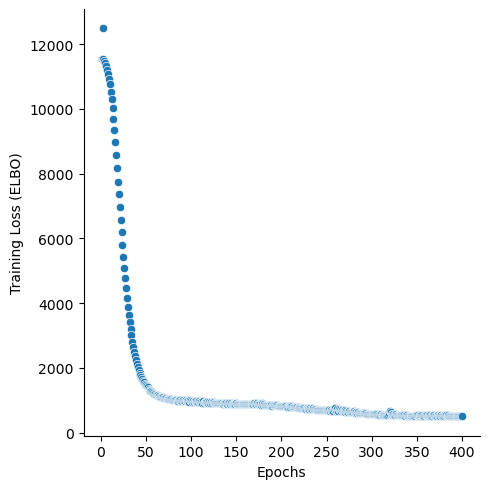

In [18]:
# train the model
epoch_losses = training_loop(model=full_model, dataloader=lung_dataloader, epochs=NUM_EPOCHS)

# visualize training loss over epochs
ax = sns.relplot(x=np.linspace(1, NUM_EPOCHS, NUM_EPOCHS),y=epoch_losses)
ax.set(xlabel="Epochs", ylabel="Training Loss (ELBO)",)
# print(f"Epoch {epoch + 1}, Loss: {train_loss / len(dataloader.dataset):.4f}")

The model converges in about ~300 epochs. Let's see well the predicted drug response correlates with the actual response.

In [19]:
def evaluate_model(model, dataloader, visualize=True):
    """Evaluate a trained model"""
    
    model.eval()
    all_predictions = []
    all_targets = []
    total_loss = 0.0
    with torch.no_grad():
        for training_batch, target_batch in dataloader:
            predicted, mu, logvar = model(training_batch)
            # track validation loss over batches
            loss = vae_loss_function(predicted, target_batch, mu, logvar)
            total_loss += loss.item()
            # track predicted and target values
            all_predictions.append(predicted)
            all_targets.append(target_batch)
    
    # concatenate tensors
    all_predictions = torch.cat(all_predictions, dim=0).numpy()
    all_targets = torch.cat(all_targets, dim=0).numpy()
    
    # compute metrics
    pearson_r, _ = pearsonr(all_targets.flatten(), all_predictions.flatten())
    spearman_r, _ = spearmanr(all_targets.flatten(), all_predictions.flatten())
    mse = mean_squared_error(all_targets.flatten(), all_predictions.flatten())
    average_loss = total_loss / len(dataloader.dataset)
    
    # save metrics to output dictionary
    metrics_dict = {
        "pearson_r": pearson_r,
        "spearman_rho": spearman_r,
        "loss": average_loss,
        "mse": mse,
        "predictions": all_predictions
    }
    
    if visualize:
        ax = sns.jointplot(x=all_targets.flatten(), y=all_predictions.flatten(), kind="kde")
        ax.ax_joint.set(xlabel="Actual response", ylabel="Predicted response")

    return metrics_dict

In [20]:
# evaluate model performance on entire dataset

full_metrics_dict = evaluate_model(full_model, lung_dataloader, visualize=False)

In [21]:
print(
    f"MSE in target response: {full_metrics_dict['mse']:.4f}, \
    Pearson R: {full_metrics_dict['pearson_r']:.4f}, \
    Spearman rho: {full_metrics_dict['spearman_rho']:.4f}"
)

MSE in target response: 0.5305,     Pearson R: 0.9565,     Spearman rho: 0.9437


The model performs remarkably well, with very high Pearson and Spearman correlation, and an MSE in drug response prediction of only about 0.5 units.


## Evaluating the model: cross validation

In the previous section, I used all the data to train the model, and then predicted on the entire dataset again. Therefore it isn't too surprising that we get good model performance. To get a better sense of generalizability, I will perform k-fold cross validation, training on 80% of the data and predicting on the remaining 20%.

If the model is significantly overfitting to the training data, I would expect to see much worse performance on the validation set.

In [22]:
from sklearn.model_selection import KFold


--- Fold 1/5 ---


Training Epoch: 100%|██████████████████████████████████████████████████████████████████| 400/400 [00:28<00:00, 13.90it/s]


Training metrics
MSE in target response: 0.5296,         Pearson R: 0.9564,         Spearman rho: 0.9431
Validation metrics
MSE in target response: 0.5581,         Pearson R: 0.9545,         Spearman rho: 0.9398

--- Fold 2/5 ---


Training Epoch: 100%|██████████████████████████████████████████████████████████████████| 400/400 [00:28<00:00, 14.04it/s]


Training metrics
MSE in target response: 0.5014,         Pearson R: 0.9586,         Spearman rho: 0.9455
Validation metrics
MSE in target response: 0.6739,         Pearson R: 0.9433,         Spearman rho: 0.9288

--- Fold 3/5 ---


Training Epoch: 100%|██████████████████████████████████████████████████████████████████| 400/400 [00:29<00:00, 13.64it/s]


Training metrics
MSE in target response: 0.5131,         Pearson R: 0.9581,         Spearman rho: 0.9453
Validation metrics
MSE in target response: 0.6170,         Pearson R: 0.9490,         Spearman rho: 0.9315

--- Fold 4/5 ---


Training Epoch: 100%|██████████████████████████████████████████████████████████████████| 400/400 [00:28<00:00, 13.98it/s]


Training metrics
MSE in target response: 0.5380,         Pearson R: 0.9554,         Spearman rho: 0.9412
Validation metrics
MSE in target response: 0.6261,         Pearson R: 0.9497,         Spearman rho: 0.9366

--- Fold 5/5 ---


Training Epoch: 100%|██████████████████████████████████████████████████████████████████| 400/400 [00:28<00:00, 14.15it/s]


Training metrics
MSE in target response: 0.5576,         Pearson R: 0.9565,         Spearman rho: 0.9438
Validation metrics
MSE in target response: 0.7229,         Pearson R: 0.9419,         Spearman rho: 0.9225


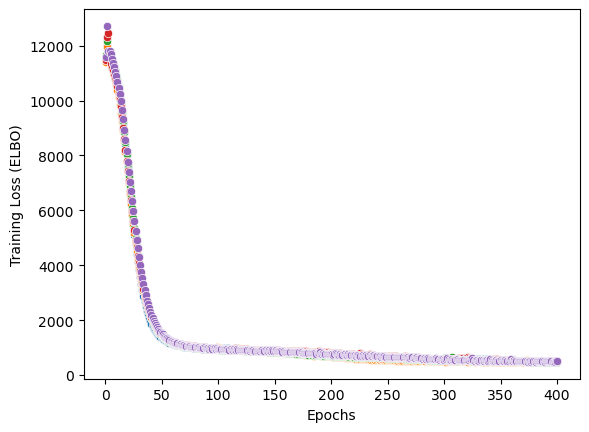

In [23]:
fig,ax = plt.subplots()
ax.set(xlabel="Epochs", ylabel="Training Loss (ELBO)")

n_folds=5
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(kfold.split(lung_dataset), start=1):
    print(f"\n--- Fold {fold}/{n_folds} ---")
    train_subset = Subset(lung_dataset, train_idx)
    val_subset = Subset(lung_dataset, val_idx)

    # define the dataloaders
    train_loader = DataLoader(
            train_subset, batch_size=BATCH_SIZE, shuffle=True
        )
    val_loader = DataLoader(
        val_subset, batch_size=BATCH_SIZE, shuffle=False
    )

    # instantiate the model
    cross_val_model = VAE(input_dim=lung_training_data.shape[1], output_dim=lung_target_data.shape[1])
    optimizer = torch.optim.Adam(cross_val_model.parameters(), lr=LEARNING_RATE)
    
    # train the model
    epoch_losses = training_loop(model=cross_val_model, dataloader=train_loader,epochs=NUM_EPOCHS)
    sns.scatterplot(x=np.linspace(1, NUM_EPOCHS, NUM_EPOCHS),y=epoch_losses, ax=ax)
    
    # evaluate on training dataset
    train_metrics_dict = evaluate_model(cross_val_model, train_loader, visualize=False)
    print("Training metrics")
    print(
        f"MSE in target response: {train_metrics_dict['mse']:.4f}, \
        Pearson R: {train_metrics_dict['pearson_r']:.4f}, \
        Spearman rho: {train_metrics_dict['spearman_rho']:.4f}"
    )
    
    # evaluate on validation dataset
    val_metrics_dict = evaluate_model(cross_val_model, val_loader, visualize=False)
    print("Validation metrics")
    print(
        f"MSE in target response: {val_metrics_dict['mse']:.4f}, \
        Pearson R: {val_metrics_dict['pearson_r']:.4f}, \
        Spearman rho: {val_metrics_dict['spearman_rho']:.4f}"
    )

Interstingly, even in a cross validation setting, the model performance is very strong: the Pearson and Spearman correlations are nearly as good as on the training data, but the mean squared error is slightly worse, as we would expect! 

## Evaluating the model: predicting on skin cancer datasets 

Testing generalizability of the VAE predictive model across cancer types

### Loading skin cancer datasets

In [24]:
skin_datasets = {}
for file in os.listdir(f"Dataset/Skin"):
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(f"Dataset/Skin", file), index_col=0)
        dict_key = file.replace("_imputed", "").replace("_latest", "").replace(".csv", "").split("_")[-1]
        skin_datasets[dict_key] = df

In [25]:
skin_input_data = pd.concat([skin_datasets[key] for key in training_assays if key != "fusions"], axis=1)
skin_target_data = skin_datasets[target_assay]

In [27]:
# data loader
skin_dataset = MultiOmicDataset(np.array(skin_input_data), np.array(skin_target_data))
skin_dataloader = DataLoader(skin_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Evaluating model trained on lung cancer data

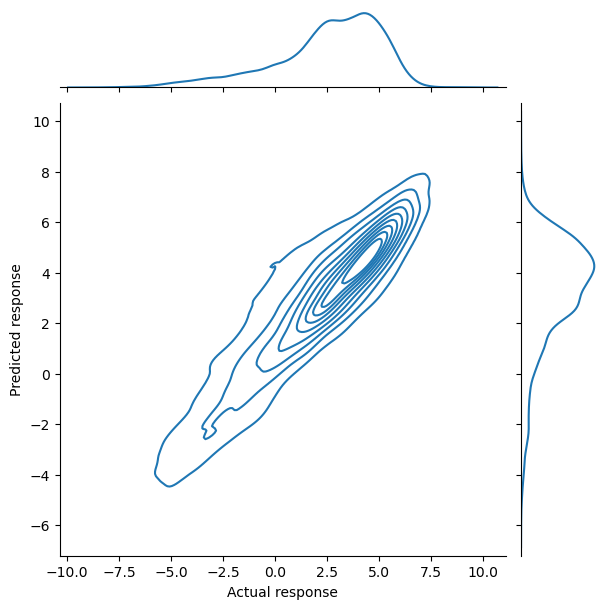

In [28]:
skin_metrics_dict = evaluate_model(full_model, skin_dataloader, visualize=True)

In [29]:
print(
    f"MSE in target response: {skin_metrics_dict['mse']:.4f}, \
    Pearson R: {skin_metrics_dict['pearson_r']:.4f}, \
    Spearman rho: {skin_metrics_dict['spearman_rho']:.4f}"
    )

MSE in target response: 1.7931,     Pearson R: 0.8978,     Spearman rho: 0.8811


**Observation**

The model actually performs quite well even on holdout data from the skin cancer dataset suggesting that it does in fact have pretty good generalizability. 

## Best predicted drug responses

Here, I'll investigate if there are particular drugs for which the model is particularly good at predicting the response. For this analysis, I'll use the version of the model trained on the entire lung cancer dataset.

### Compute MSE of predictions by drug

In [30]:
predicted_drug_response = full_metrics_dict["predictions"]
prediction_errors_df = pd.DataFrame(np.sqrt((predicted_drug_response - np.array(lung_target_data))**2), \
                                    index=lung_target_data.index, 
                                    columns=lung_target_data.columns)

In [31]:
mse_prediction_error = prediction_errors_df.mean().reset_index().rename(columns={"index":"drug", 0: "error"})
mse_prediction_error["drug_name"] = mse_prediction_error["drug"].apply(lambda x: x.split(";")[1])

In [34]:
mse_prediction_error.sort_values(by="error").head(20)[["drug_name", "error"]]

,drug_name,error
488,Lasalocid,0.298212
413,SGC0946,0.312437
211,LDN-193189,0.322423
33,GSK319347A,0.340420
217,Wnt-C59,0.346162
47,Bicalutamide,0.353200
412,UNC0642,0.353787
216,LGK974,0.360628
212,FTY-720,0.360907
85,GSK1904529A,0.364145


I want to now explore whether the model is good at predicting drug responses uniformly across the dynamic range of the assay, or does it excel at low vs high responses?

### Compare MSE  vs mean response by drug

In [35]:
mean_response_by_drug = lung_target_data.mean().reset_index().rename(columns={"index":"drug", 0: "mean_response"})

In [36]:
merged_df = mean_response_by_drug.merge(mse_prediction_error, on='drug')

<AxesSubplot:xlabel='mean_response', ylabel='error'>

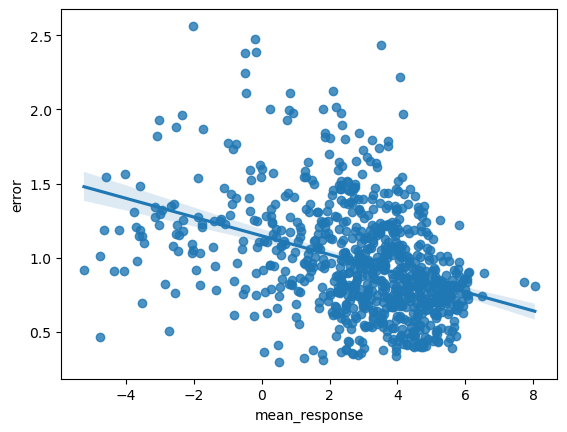

In [37]:
sns.regplot(data=merged_df, x="mean_response", y="error")

In [38]:
print(
f"Correlation between mean prediction error and mean response by drug: \
{pearsonr(merged_df.mean_response, merged_df.error)[0]:.4f}"
)


Correlation between mean prediction error and mean response by drug: -0.3784


This is very interesting, it appears that model predictions are generally noisier for drugs with a lower mean response

# Potential next steps

This is a fascinating dataset to be playing around with. Questions / thoughts I'd address given more time include the following:

**Biological questions**
- Other predictive tasks: for instance predicting gene essentiality (i.e. CRISPR Cas9 mutagenesis response) from methylation, transcriptomics, proteomics, or predicting proteomic data from transcriptomics, etc.
- Take the drug response prediction one step further: use drug SMILES strings as model input (through some reasonable representation of chemical structures), and predict drug response. This could allow us to generate predictions for as-yet untested drugs. 

**Model architecture**
- Simpler architectures to understand how complex a model needs to be (linear models, tree-based regressors, multilayer perceptrons) but also complex models such as transformers with self-attention: where do we observe diminishing returns between model complexity and performance?

**Model training**

Here, I modified the canonical VAE architecture to predict drug response instead of reconstructing the input. I would try a few different model training approaches:
- Reconstruct the input omics data, and use the latent space representations in a predictive model for drug response.
- Play around with semi-supervised versions of VAEs where I reconstruct the input omics data, and predict drug response at the same time.
- Tune model hyperparameters systematically, play around with changing the weighting between reconstruction loss and KL divergence in the VAE
- Optimize model training on GPUs for larger datasets: I trained the models locally on ~8G CPU which is definitely not scalable. 

**Model validation**
- Systematic analysis of which datasets (from methylation, transcriptomics, proteomics) contribute the most to the model performance, removing one or two assay types systematically, and try to understand which input datasets have the most predictive power.
- Explore model generalizability across other cancer types from the Cell Passports database. Is the high generalizbility from lung to skin cancer due to similarities in the underlying mutations leading to cancer? Does predicting drug response in cancers much more different from lung cancer become difficult?
- Assess impact of imputing and preprocessing of the multi-omic datasets on model performance.

**Interpretation of drug response data**
- For the drugs where the model predictions, are better vs worse, do they target specific classes of genes, or share chemical properties? 
- Latent space visualization using PCA/UMAP: do cell lines that closely cluster in VAE space make biological sense?